# Timeseries
It is a type of data where time is one of the main components, and each value depends on previous time points.

Examples:
- Daily stock prices
- Hourly temperature
- Monthly sales
- Yearly population
- Seconds-level sensor readings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the Dataset
data = pd.read_csv('exchange_rate.csv')
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
data.shape

(7588, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [6]:
data.index

RangeIndex(start=0, stop=7588, step=1)

In [8]:
# Time Series Models Requires Date-Time index, To recognize time Ordering

data['date'] = pd.to_datetime(data['date'], dayfirst=True)

In [9]:
data.set_index('date', inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


In [11]:
# cheking missing Values
data.isnull().sum()

Ex_rate    0
dtype: int64

In [16]:
# Fill missing values using interpolation
data['Ex_rate'] = data['Ex_rate'].interpolate(method='linear')

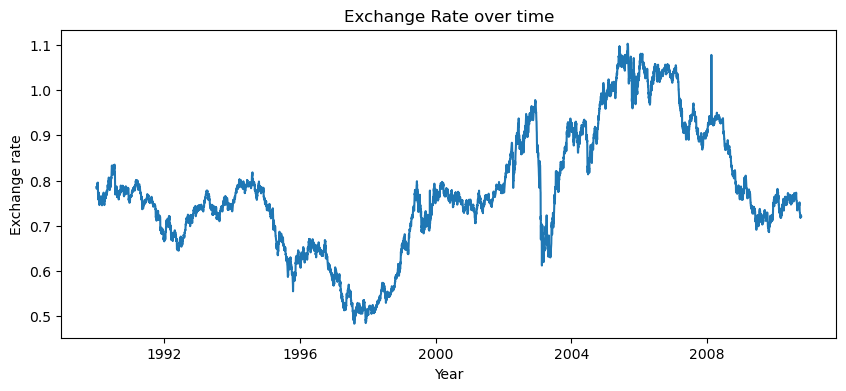

In [17]:
# Exploration of dataset
plt.figure(figsize=(10,4))
plt.plot(data['Ex_rate'])
plt.title('Exchange Rate over time')
plt.xlabel('Year')
plt.ylabel('Exchange rate')
plt.show()

#### STATIONARITY CHECK (CRITICAL FOR ARIMA)
* Stationary data = predictable behavior
* Non-stationary data = unpredictable, unstable behavior
* Modles like [ AR , MA, ARIMA, SARIMA ]
* work correctly only when the time series is stationary

In [18]:
# for stationary check we are using adfuller

from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('adf_statistics :', result[0])
    print('P-Value :', result[1])
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Not Stationary')

adf_test(data['Ex_rate'])
    

adf_statistics : -1.6649941807381343
P-Value : 0.44923273535979974
Not Stationary


In [20]:
# To Fix the Stationary with using differencing
# ARIMA requires constant mean/variance.

data_diff = data['Ex_rate'].diff().dropna()
data_diff

date
1990-01-02   -0.003700
1990-01-03    0.004900
1990-01-04   -0.000700
1990-01-05   -0.001100
1990-01-06    0.001700
                ...   
2010-10-06   -0.000207
2010-10-07    0.003345
2010-10-08    0.001358
2010-10-09   -0.002372
2010-10-10    0.000000
Name: Ex_rate, Length: 7587, dtype: float64

In [23]:
print("adf Test after differencing:")
adf_test(data_diff)

adf Test after differencing:
adf_statistics : -99.39343120118627
P-Value : 0.0
Stationary


#### Now we are going to identify ARIMA(p, q, d) using ACF & PACF
##### ACF  : Autocorrelation Function
- ACF measures how much the time series is correlated with its own past values.
##### PACF : Partial Autocorrelation Function
- PACF measures the direct relationship between the time series and its past values.

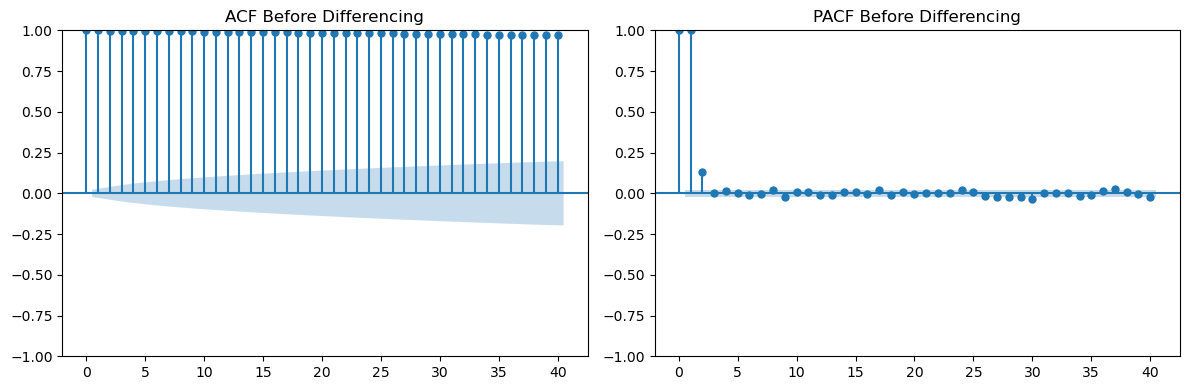

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12,4))

plot_acf(data['Ex_rate'], lags=40, ax=ax[0])
ax[0].set_title("ACF Before Differencing")

plot_pacf(data['Ex_rate'], lags=40, ax=ax[1])
ax[1].set_title("PACF Before Differencing")

plt.tight_layout()
plt.show()

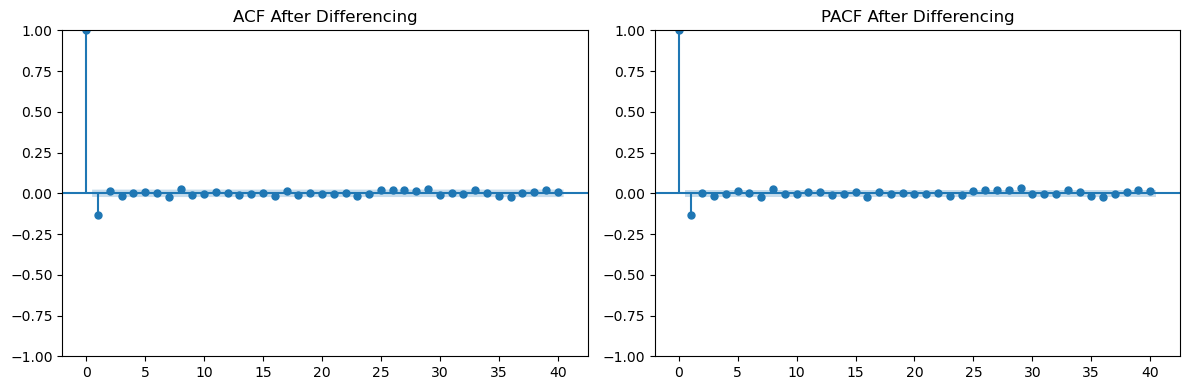

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

plot_acf(data_diff, lags=40, ax=ax[0])
ax[0].set_title("ACF After Differencing")

plot_pacf(data_diff, lags=40, ax=ax[1])
ax[1].set_title("PACF After Differencing")

plt.tight_layout()
plt.show()

- Exactly ARIMA Parameters we are not sure as per plot
- will use auto-arima for Hyperparameter tuning(auto-Arima)

In [31]:
# before find parameters need to create train&test split

train = data['Ex_rate'][:-365]
test = data['Ex_rate'][-365:]

print('Train Length :',len(train))
print('Test length :',len(test))

Train Length : 7223
Test length : 365


In [33]:
from pmdarima import auto_arima

best_model = auto_arima(train,
                       start_P=0, max_p=5,
                       start_q=0, max_q=5,
                       start_d=0, max_d=2,
                       seasonal=True,
                       trace=True)
best_model.order

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-53253.877, Time=3.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-53130.193, Time=2.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-53255.863, Time=2.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-53254.558, Time=3.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-53132.181, Time=1.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-53253.881, Time=4.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-53251.869, Time=11.48 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-53257.848, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-53255.861, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-53255.866, Time=1.46 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-53256.543, Time=1.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-53253.860, Time=3.43 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 35.522 seconds


(1, 1, 0)

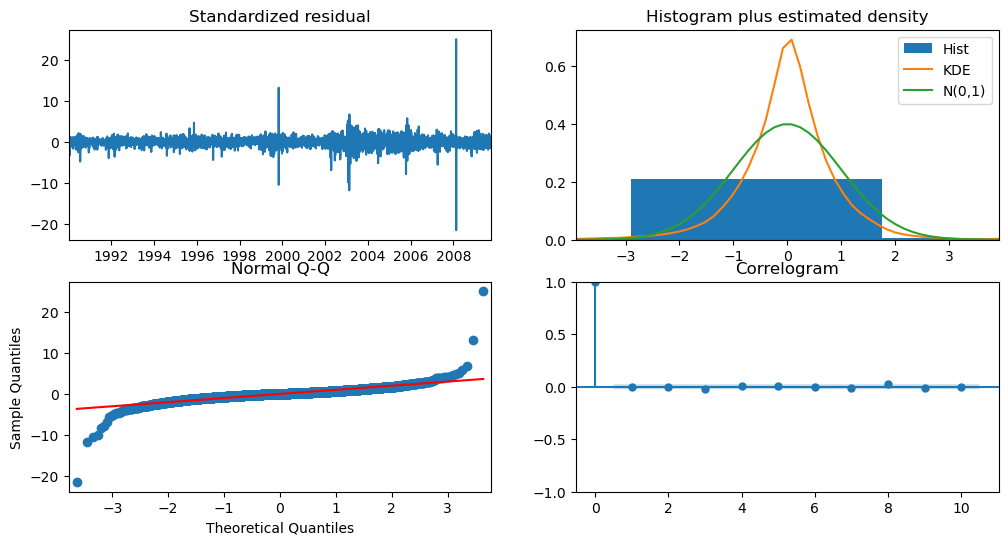

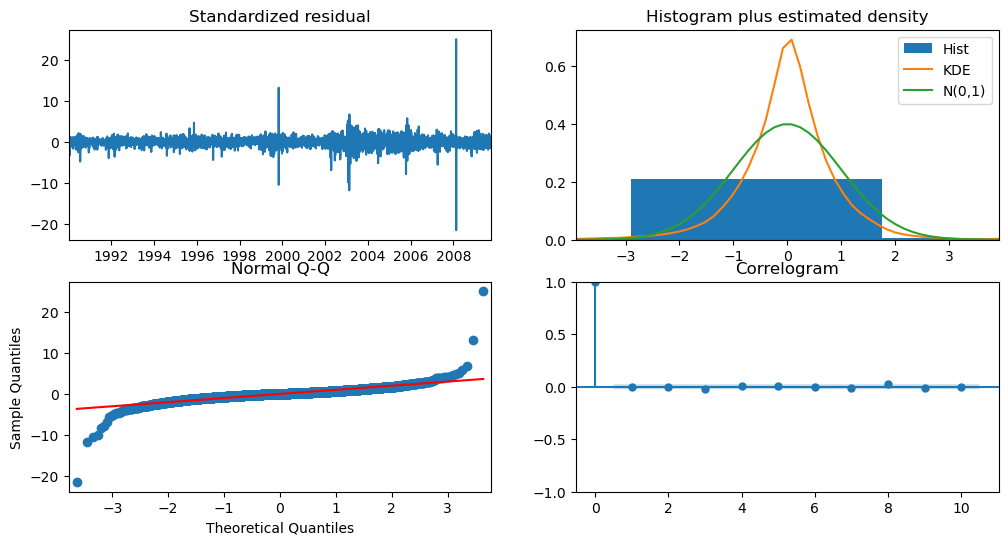

In [63]:
best_model.plot_diagnostics(figsize=(12,6))

#### FIT ARIMA MODEL WITH BEST PARAMETERS

In [66]:
from statsmodels.tsa.arima.model import ARIMA

p,d,q = best_model.order
arima_model = ARIMA(train, order=(p,d,q))
model_fit = arima_model.fit()

In [67]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7223
Model:                 ARIMA(1, 1, 0)   Log Likelihood               26630.924
Date:                Mon, 02 Feb 2026   AIC                         -53257.848
Time:                        20:21:59   BIC                         -53244.078
Sample:                    01-01-1990   HQIC                        -53253.110
                         - 10-10-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1324      0.002    -63.577      0.000      -0.136      -0.128
sigma2       3.67e-05   1.04e-07    354.247      0.000    3.65e-05    3.69e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2762499.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               3.38   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### forecast for next 365 Days

In [36]:
arima_forecast = model_fit.forecast(steps=365)

#### EXPONENTIAL SMOOTHING (HOLT-WINTERS)

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
ES = ExponentialSmoothing(train, trend='add', seasonal=None)
ES_fit = ES.fit()

In [39]:
ES_forecast = ES_fit.forecast(365)

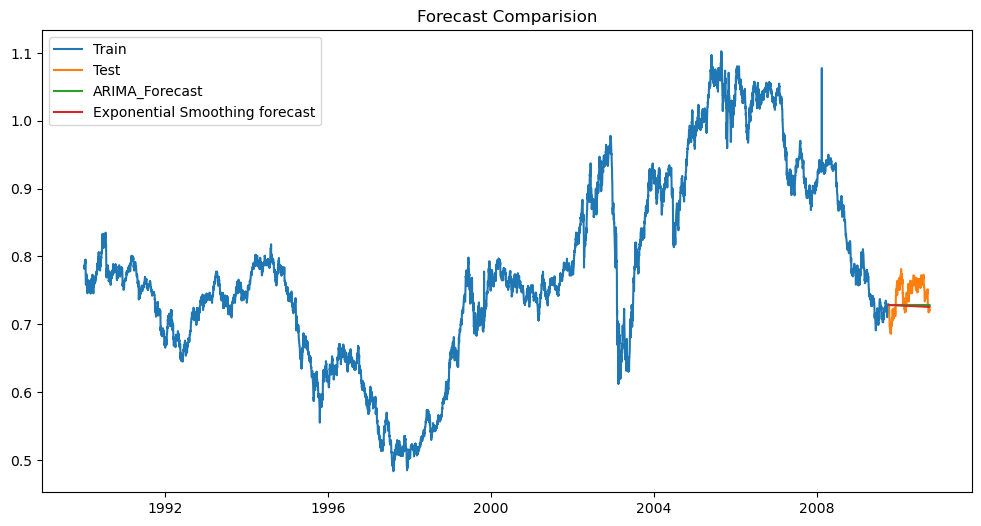

In [52]:
# FORECAST VISUALIZATION

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA_Forecast')
plt.plot(test.index, ES_forecast, label='Exponential Smoothing forecast')
plt.title('Forecast Comparision')
plt.legend()
plt.show()

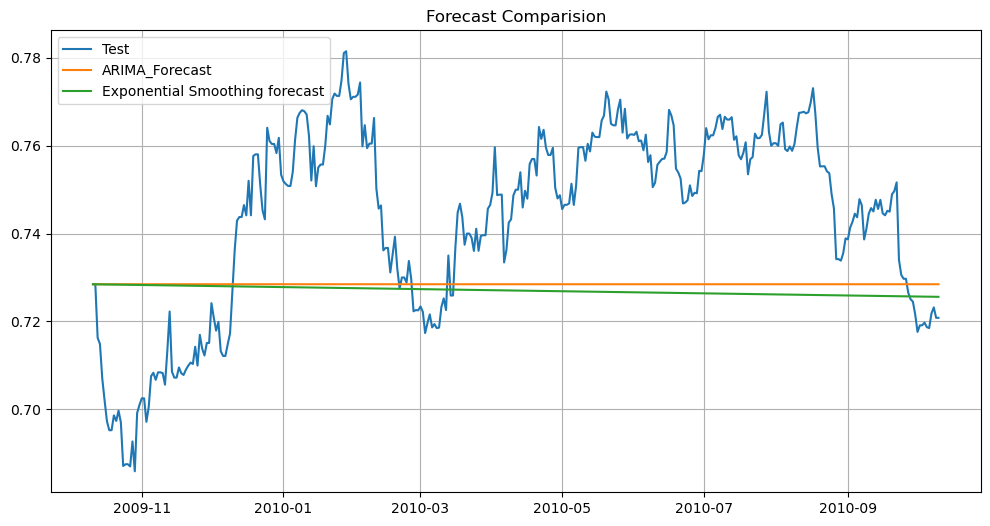

In [54]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA_Forecast')
plt.plot(test.index, ES_forecast, label='Exponential Smoothing forecast')
plt.title('Forecast Comparision')
plt.legend()
plt.grid()
plt.show()

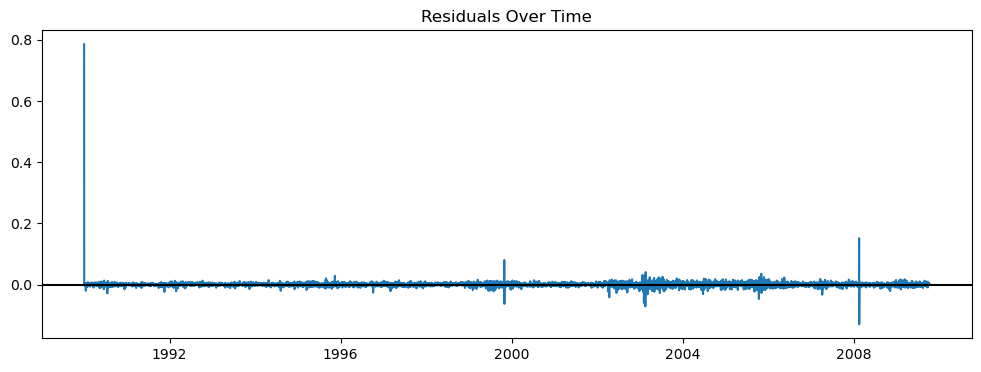

In [60]:
arima_model = ARIMA(train, order=(1,1,0)).fit()
arima_fitted = arima_model.fittedvalues
residuals = train - arima_fitted

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.axhline(0, color='black')
plt.show()


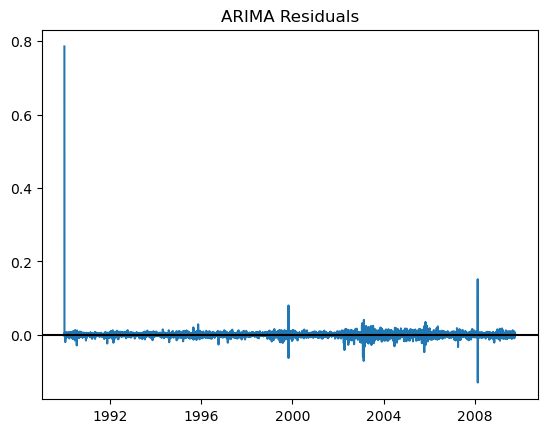

In [61]:
plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.axhline(0, color="black")
plt.show()


### MODEL EVALUATION (MAE, RMSE, MAPE)

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [90]:
def Evaluate(actual, predicted):
    MAE = mean_absolute_error(actual, predicted)
    MSE = mean_squared_error(actual, predicted)
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((actual-predicted)/actual)) * 100
    return MAE, MSE, RMSE, MAPE

arima_MAE, arima_MSE, arima_RMSE, arima_MAPE = Evaluate(test, arima_forecast)
ES_MAE, ES_MSE, ES_RMSE, ES_MAPE = Evaluate(test, ES_forecast)


Results = pd.DataFrame({'ARIMA':[arima_MAE, arima_MSE, arima_RMSE, arima_MAPE],
                   'Exponential':[ES_MAE, ES_MSE, ES_RMSE, ES_MAPE]},
                       index=['MAE', 'MSE', 'RMSE', 'MAPE'])

print(Results)

         ARIMA  Exponential
MAE   0.023388     0.024420
MSE   0.000688     0.000750
RMSE  0.026229     0.027393
MAPE  3.122351     3.257913


In [91]:
print("========== FINAL CONCLUSION ==========")

if arima_MAPE < ES_MAPE:
    print("ARIMA is the best model for this dataset.")
else:
    print("Exponential Smoothing is the best model for this dataset.")


========== FINAL CONCLUSION ==========
ARIMA is the best model for this dataset.


  
Result : MAPE: 3.122351464488249

- MAPE < 10% = Good
- MAPE < 5%  = Very Good
- MAPE < 3%  = Excellent

- The ARIMA model outperformed Exponential Smoothing and provided reliable exchange-rate forecasts with low error, making it the preferred model for this dataset.